# Machine Learning Tree Methods

How to use tree-based machine learning models to predict future values of a stock's price, as well as how to use forest-based machine learning methods for regression and feature selection.

In [48]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid, GridSearchCV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import talib as ta
from config import datapaths
from feature_enfineering import FeatureEngineer

In [2]:
ta.__version__

'0.4.19'

One problem with linear models is that we must manually add feature interactions. However, as we are going to see in this notebook, other models are able to learn non-linear relationships between features and targets. These include decision-tree-based models such as random forests and gradient boosting among many others, and neural networks.

The more sophisticated models allow us to engineer more features, which can lead to a significant improvement of the predictive performance.

We will use the volume data as one new feature.

In [3]:
lng_total = pd.read_csv(datapaths['LNG'], parse_dates=['Date'], index_col='Date')
lng_total.head()

,Adj_Close,Adj_Volume
Date,,
1994-04-04,72.0,0.0
1994-04-05,108.0,0.0
1994-04-06,108.0,0.0
1994-04-07,108.0,0.0
1994-04-08,108.0,0.0


In [4]:
lng_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6052 entries, 1994-04-04 to 2018-04-16
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Adj_Close   6052 non-null   float64
 1   Adj_Volume  6052 non-null   float64
dtypes: float64(2)
memory usage: 141.8 KB


In [5]:
lng = lng_total.loc['2016-04-15':].copy()

In [6]:
fe = FeatureEngineer(lng)
fe.create_moving_averages([14, 30, 50 ,200], colnames=['Adj_Close'])
fe.create_rsi([14, 30, 50 ,200], colnames=['Adj_Close'])
fe.df

,Adj_Close,Adj_Volume,ma_14,ma_30,ma_50,ma_200,rsi_14,rsi_30,rsi_50,rsi_200
Date,,,,,,,,,,
2016-04-15,37.13,4293775.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-18,36.90,3445852.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-19,37.12,3748050.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-20,37.77,2470384.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-21,37.21,2043988.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-04-10,55.63,3430268.0,0.964343,0.962886,0.984569,0.885689,56.694826,53.669051,53.634818,53.225104
2018-04-11,56.25,2875489.0,0.956394,0.953209,0.972725,0.876694,58.867940,54.837252,54.387150,53.441208
2018-04-12,56.20,1539915.0,0.962557,0.956240,0.973310,0.878181,58.612496,54.722143,54.314625,53.421204


In [7]:
lng = fe.df.copy()

In [8]:
feature_names: list = list(lng.drop(['Adj_Close', 'Adj_Volume'], axis=1).columns)
feature_names

['ma_14', 'ma_30', 'ma_50', 'ma_200', 'rsi_14', 'rsi_30', 'rsi_50', 'rsi_200']

In [9]:
lng['5d_future_close'] = lng['Adj_Close'].shift(-5)
lng['5d_close_future_ret'] = lng['5d_future_close'].pct_change(5)
lng['5d_close_ret'] = lng['Adj_Close'].pct_change(5)
lng.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 504 entries, 2016-04-15 to 2018-04-16
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Adj_Close            504 non-null    float64
 1   Adj_Volume           504 non-null    float64
 2   ma_14                491 non-null    float64
 3   ma_30                475 non-null    float64
 4   ma_50                455 non-null    float64
 5   ma_200               305 non-null    float64
 6   rsi_14               490 non-null    float64
 7   rsi_30               474 non-null    float64
 8   rsi_50               454 non-null    float64
 9   rsi_200              304 non-null    float64
 10  5d_future_close      499 non-null    float64
 11  5d_close_future_ret  499 non-null    float64
 12  5d_close_ret         499 non-null    float64
dtypes: float64(13)
memory usage: 55.1 KB


In [10]:
feature_names.extend(['5d_close_ret'])
feature_names

['ma_14',
 'ma_30',
 'ma_50',
 'ma_200',
 'rsi_14',
 'rsi_30',
 'rsi_50',
 'rsi_200',
 '5d_close_ret']

In [11]:
new_features: list = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)

lng['Adj_Volume_1d_change'] = lng['Adj_Volume'].pct_change()
lng['Adj_Volume_1d_change_SMA'] = ta.SMA(lng['Adj_Volume_1d_change'].to_numpy(), timeperiod=5)

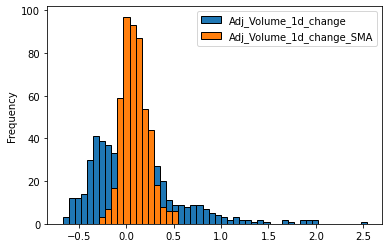

In [12]:
lng[new_features].plot(kind='hist', bins=50, edgecolor='k')
plt.show()

We can see the moving average of volume changes has a much smaller range than the raw data.

In [22]:
days_of_week = pd.get_dummies(lng.index.dayofweek,
                              prefix='weekday',
                              drop_first=True)
days_of_week.head()

,weekday_1,weekday_2,weekday_3,weekday_4
0,0,0,0,1
1,0,0,0,0
2,1,0,0,0
3,0,1,0,0
4,0,0,1,0


In [23]:
days_of_week.index = lng.index
lng = pd.concat([lng, days_of_week], axis=1)
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
lng.dropna(inplace=True)
lng.head()

,Adj_Close,Adj_Volume,ma_14,ma_30,ma_50,ma_200,rsi_14,rsi_30,rsi_50,rsi_200,5d_future_close,5d_close_future_ret,5d_close_ret,Adj_Volume_1d_change,Adj_Volume_1d_change_SMA,weekday_1,weekday_2,weekday_3,weekday_4
Date,,,,,,,,,,,,,,,,,,,
2017-01-31,47.65,2137394.0,0.950697,0.918657,0.895731,0.839267,62.968946,60.655749,57.951677,53.695377,47.81,0.003358,0.043812,-0.175332,-0.000664,1,0,0,0
2017-02-01,47.10,2051631.0,0.967486,0.932427,0.910110,0.850150,60.156019,59.159791,57.041713,53.487663,48.01,0.019321,-0.023429,-0.040125,-0.165783,0,1,0,0
2017-02-02,49.33,3081369.0,0.932220,0.895486,0.873379,0.812956,66.659314,62.988478,59.662227,54.209475,49.19,-0.002838,-0.021618,0.501912,-0.081419,0,0,1,0
2017-02-03,49.43,4158130.0,0.938976,0.899461,0.875497,0.812490,66.920059,63.148741,59.774509,54.241479,48.93,-0.010115,0.007336,0.349442,0.108332,0,0,0,1
2017-02-06,48.50,2090909.0,0.964080,0.921608,0.895860,0.829234,62.059184,60.623276,58.236185,53.889442,48.14,-0.007423,0.022129,-0.497152,0.027749,0,0,0,0


In [24]:
lng.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 299 entries, 2017-01-31 to 2018-04-09
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Adj_Close                 299 non-null    float64
 1   Adj_Volume                299 non-null    float64
 2   ma_14                     299 non-null    float64
 3   ma_30                     299 non-null    float64
 4   ma_50                     299 non-null    float64
 5   ma_200                    299 non-null    float64
 6   rsi_14                    299 non-null    float64
 7   rsi_30                    299 non-null    float64
 8   rsi_50                    299 non-null    float64
 9   rsi_200                   299 non-null    float64
 10  5d_future_close           299 non-null    float64
 11  5d_close_future_ret       299 non-null    float64
 12  5d_close_ret              299 non-null    float64
 13  Adj_Volume_1d_change      299 non-null    floa

Now that we have our volume and datetime features, we want to check the correlations between our new features (stored in the `new_features` list) and the target (`5d_close_future_pct`) to see how strongly they are related. 

In [26]:
new_features.extend(['weekday_' + str(i) for i in range(1, 5)])

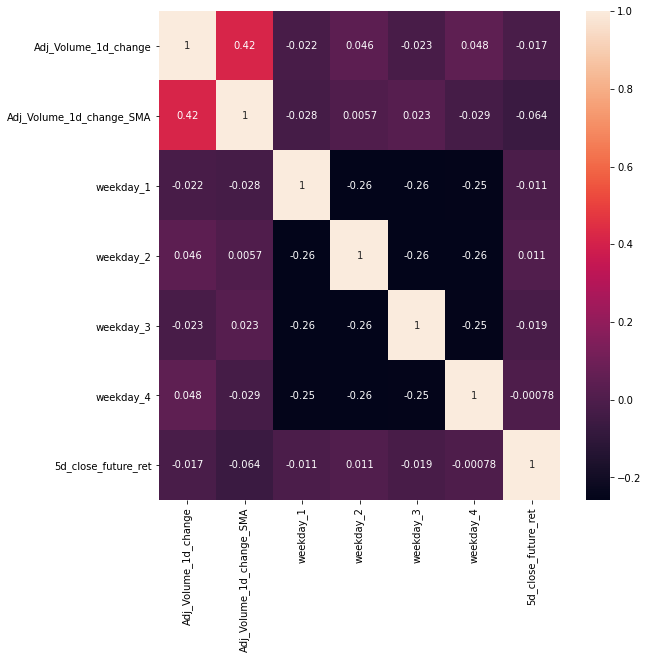

In [29]:
plt.figure(figsize=(9, 9))
sns.heatmap(lng[new_features  + ['5d_close_future_ret']].corr(), annot=True)
plt.show()

Even though the correlations are weak, they may improve our predictions via interactions with other features.

## Decision Trees

Random forests are a go-to model for predictions; they work well out of the box. But we'll first learn the building block of random forests (decision trees).

Decision trees split the data into groups based on the features. Decision trees start with a root node, and split the data down until we reach leaf nodes.

Without limiting the tree's depth (or height), it will keep splitting the data until each leaf has 1 sample in it, which is the epitome of overfitting.

In [39]:
train_features = lng[feature_names].iloc[:250, :].copy()
train_targets = lng['5d_close_future_ret'].iloc[:250].copy()

test_features = lng[feature_names].iloc[250:, :].copy()
test_targets = lng['5d_close_future_ret'].iloc[250:].copy()

print(train_features.shape, test_features.shape)

(250, 15) (49, 15)


In [40]:
decision_tree = DecisionTreeRegressor()

decision_tree.fit(train_features, train_targets)

print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features, test_targets))

1.0
-1.6121985851234264


We obtained a perfect fit on the training data. However, the score is terrible on the test data. This is clearly due to overfitting.

We always want to optimize our machine learning models to make the best predictions possible. We can do this by **tuning hyperparameters**, which are settings for our models.

For regular [decision trees](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor), probably the most important hyperparameter is `max_depth`. This limits the number of splits in a decision tree. Let's find the best value of max_depth based on the $R^2$ score of our model on the test set, which we can obtain using the `score()` method of our decision tree models.

In [42]:
for d in [3, 5, 10]:
    decision_tree = DecisionTreeRegressor(max_depth=d)
    decision_tree.fit(train_features, train_targets)

    print(f'max_depth={d}')
    print(decision_tree.score(train_features, train_targets))
    print(decision_tree.score(test_features, test_targets), '\n')

max_depth=3
0.313332035717818
-0.3690285792942267 

max_depth=5
0.5117261722974892
-0.9639866863634428 

max_depth=10
0.8989892189602487
-0.7165063442881854 



Once we have an optimized model, we want to check how it is performing in more detail. We already saw the $R^2$ score, but it can be helpful to see the predictions plotted vs actual values. We can use the `.predict()` method of our decision tree model to get predictions on the train and test sets.

Ideally, we want to see **diagonal lines from the lower left to the upper right**. However, due to the simplicity of decisions trees, our model is not going to do well on the test set. But it will do well on the train set.

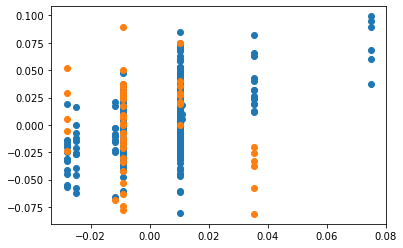

In [43]:
decision_tree = DecisionTreeRegressor(max_depth=3)
decision_tree.fit(train_features, train_targets)

train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

plt.scatter(train_predictions, train_targets, label='train', edgecolor='k')
plt.scatter(test_predictions, test_targets, label='test', edgecolor='k')
plt.show()

The predictions group into lines because our depth is limited.

## Random forests

Random forests were created to reduce the variance of decision trees. As we have seen before, decision trees can work well on training data, but not so weel on test data. Meaning that the predictions greatly vary on the training set and predict poorly on the test set. The opposite of a high-variance model is a high-bias model like a linear fit that is able to capture the general trend but misses small details. Random forests balance between high-variance and high-bias models.

Random forests are name as such because they're a collection of decision trees. These have differences in the way trees are created.

First, we sample with replacement from our training set to get datasets for each tree we fit. This is bootstrap aggregating (or bagging). It is implied that we can have repeated observations in our sample. We may also omit some data points.

Another difference between normal decision trees and random forests is how splits happen. Instead of tryping splis on all features, we sample a smaller number of features for each split. This helps to reduce the variance of our model.

In [46]:
random_forest = RandomForestRegressor(n_estimators=200)
random_forest.fit(train_features, train_targets)
random_forest.score(test_features, test_targets)

-0.1262063975163572

### Tuning hyperparameters

In [67]:
grid = dict(n_estimators=[200], max_depth=[3], max_features=[4, 8], random_state=[21])

test_scores: list = []
    
for g in ParameterGrid(grid):
    random_forest.set_params(**g)
    print(g)
    random_forest.fit(train_features, train_targets)
    test_scores.append(random_forest.score(test_features, test_targets))

best_idx: int = np.argmax(test_scores)
print("Best score:", test_scores[best_idx])
print("Best hyperparameter mix:", ParameterGrid(grid)[best_idx])

{'max_depth': 3, 'max_features': 4, 'n_estimators': 200, 'random_state': 21}
{'max_depth': 3, 'max_features': 8, 'n_estimators': 200, 'random_state': 21}
Best score: 0.0007521769649113663
Best hyperparameter mix: {'random_state': 21, 'n_estimators': 200, 'max_features': 8, 'max_depth': 3}


To see how this mix performs on various random states:

In [59]:
best_grid = {'random_state': list(range(100)), 'n_estimators': [200], 'max_features': [8], 'max_depth': [3]}

best_test_scores: list = []

for g in ParameterGrid(best_grid):
    random_forest.set_params(**g)
    random_forest.fit(train_features, train_targets)
    best_test_scores.append(random_forest.score(test_features, test_targets))

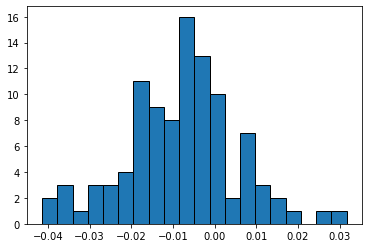

In [60]:
plt.hist(best_test_scores, edgecolor='k', bins=20)
plt.show()

This result is not very good as our hyperparameter's mix most of the time yields a negative $R^2$ than positive...

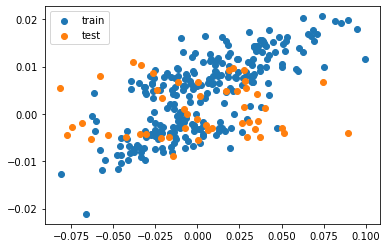

In [68]:
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=21)
rfr.fit(train_features, train_targets)
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets, test_predictions, label='test')
plt.legend()
plt.show()

We can see our train predictions are good, but test predictions (generalization) are not great.

### GridSearchCV

In [81]:
param_grid = dict(n_estimators=[200], max_depth=[3, 5, 10], max_features=[4, 8], random_state=[21])

rfr = RandomForestRegressor()

rfr_cv = GridSearchCV(rfr, param_grid)
    
rfr_cv.fit(train_features, train_targets)

print(rfr_cv.best_score_)
print(rfr_cv.best_params_)

-0.4115233873080798
{'max_depth': 3, 'max_features': 4, 'n_estimators': 200, 'random_state': 21}
